In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

# Dataset paths
DATA_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
COVID_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"
PRASHANT_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data"
NIH_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4"
BACHRR_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"

print(f"Pneumonia Dataset: {DATA_DIR}")
print(f"COVID Dataset: {COVID_DIR}")
print(f"Additional Dataset: {PRASHANT_DIR}")
print(f"NIH Dataset: {NIH_DIR}")
print(f"Bachrr Dataset: {BACHRR_DIR}")

Pneumonia Dataset: /Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
COVID Dataset: /Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
Additional Dataset: /Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data
NIH Dataset: /Users/erenaskin/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4
Bachrr Dataset: /Users/erenaskin/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4


## Class Distribution
Let's look at the total number of **Normal**, **Pneumonia**, and **COVID-19** images formed by combining 3 different datasets.

/var/folders/q4/pxv0kjln48vbk5c_hz3trv300000gn/T/ipykernel_5707/2836823875.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


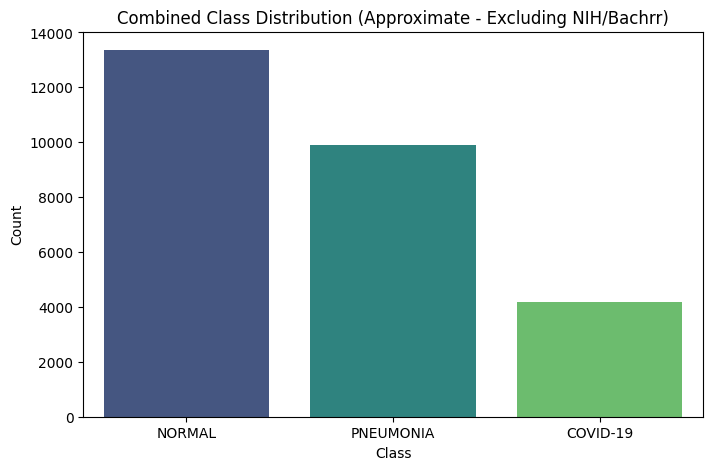

Class Counts (Subset): {'NORMAL': 13358, 'PNEUMONIA': 9891, 'COVID-19': 4192}


In [8]:
def get_combined_distribution():
    counts = {"NORMAL": 0, "PNEUMONIA": 0, "COVID-19": 0}
    
    # 1. Paul Mooney (PNEUMONIA & NORMAL)
    for split in ['train', 'test', 'val']:
        for category in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(DATA_DIR, split, category)
            if os.path.exists(path):
                counts[category] += len(os.listdir(path))
                
    # 2. Tawsifur Rahman (COVID-19 & NORMAL & Viral Pneumonia)
    covid_path = os.path.join(COVID_DIR, "COVID-19_Radiography_Dataset", "COVID", "images")
    if os.path.exists(covid_path):
        counts["COVID-19"] += len(os.listdir(covid_path))
        
    normal_path = os.path.join(COVID_DIR, "COVID-19_Radiography_Dataset", "Normal", "images")
    if os.path.exists(normal_path):
        counts["NORMAL"] += len(os.listdir(normal_path))
        
    pneumonia_path = os.path.join(COVID_DIR, "COVID-19_Radiography_Dataset", "Viral Pneumonia", "images")
    if os.path.exists(pneumonia_path):
        counts["PNEUMONIA"] += len(os.listdir(pneumonia_path))

    # 3. Prashant268 (COVID-19 & PNEUMONIA & NORMAL)
    for split in ['train', 'test']:
        for category in ['COVID19', 'PNEUMONIA', 'NORMAL']:
            path = os.path.join(PRASHANT_DIR, split, category)
            if os.path.exists(path):
                key = "COVID-19" if category == "COVID19" else category
                counts[key] += len(os.listdir(path))

    # Note: NIH and Bachrr datasets are also used in training but require CSV parsing
    # to count exact class distributions, so they are omitted from this simple count.
    # However, they contribute significantly to the diversity of the training data.
    
    return counts

counts = get_combined_distribution()
df = pd.DataFrame(list(counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
sns.barplot(x='Class', y='Count', data=df, palette='viridis')
plt.title("Combined Class Distribution (Approximate - Excluding NIH/Bachrr)")
plt.show()

print("Class Counts (Subset):", counts)

## Sample Images
Random samples from Normal, Pneumonia, and COVID-19 classes.

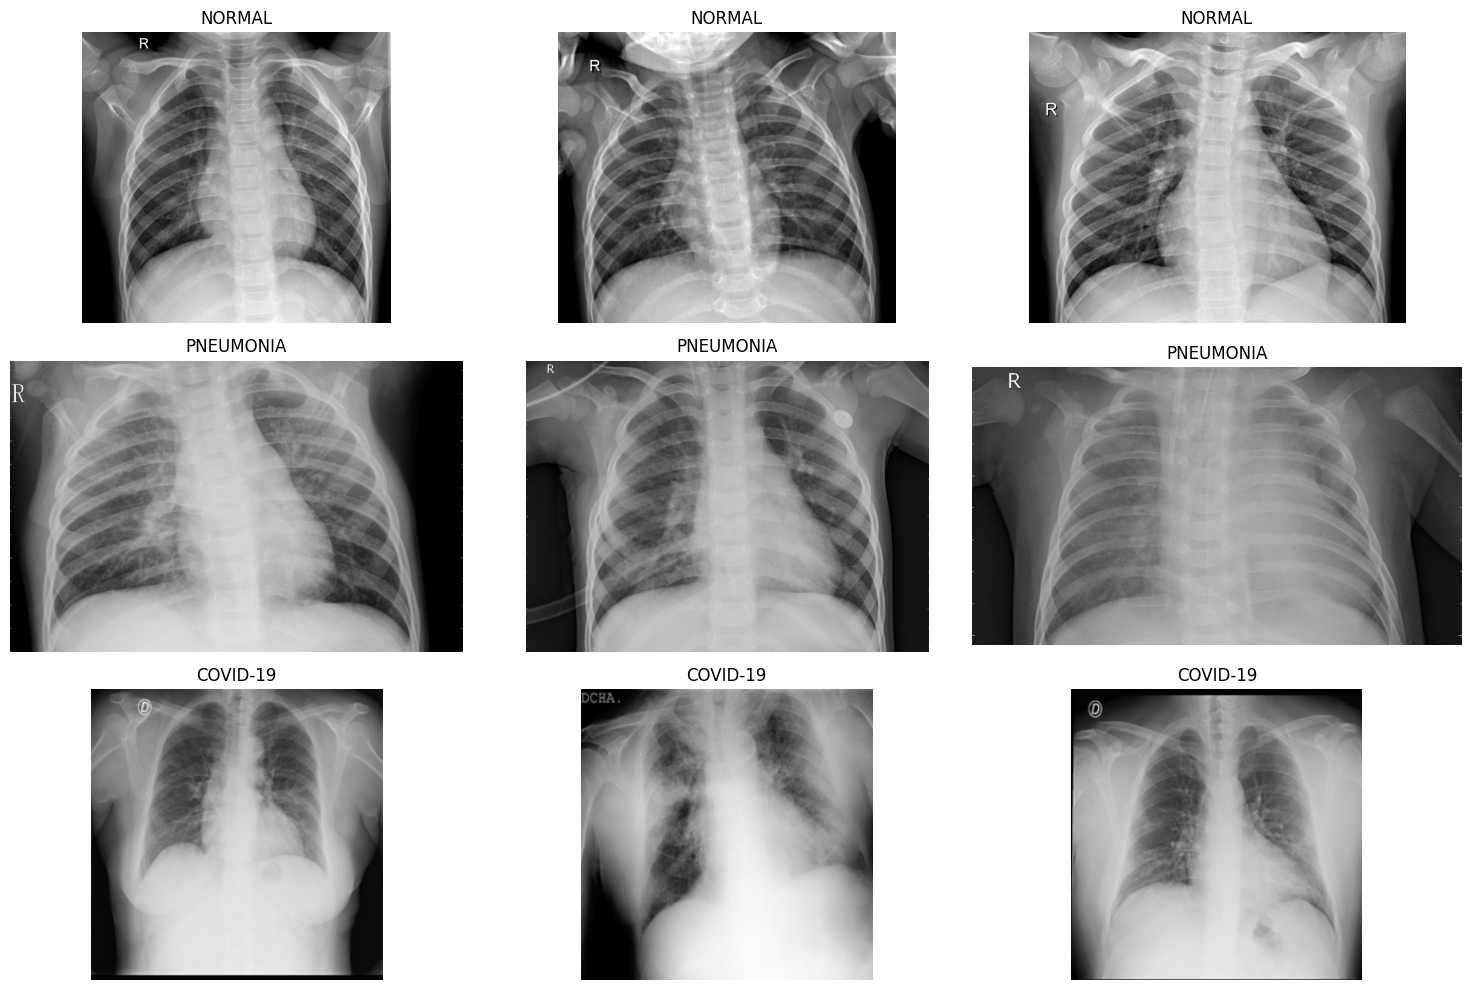

In [9]:
import random

def show_samples_combined(num_samples=3):
    plt.figure(figsize=(15, 10))
    classes = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    
    # Helper to get random images from the sources
    def get_random_images(label, n):
        images = []
        
        # 1. DATA_DIR
        if label in ['NORMAL', 'PNEUMONIA']:
            p = os.path.join(DATA_DIR, 'train', label)
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpeg', '.jpg', '.png'))]
                images.extend(imgs)
        
        # 2. COVID_DIR & ADDITIONAL_DIR (For COVID-19)
        if label == 'COVID-19':
            # COVID_DIR
            files = glob.glob(os.path.join(COVID_DIR, '**', 'COVID', 'images', '*.png'), recursive=True)
            images.extend(files)
                
            # PRASHANT_DIR
            p = os.path.join(PRASHANT_DIR, 'train', 'COVID19')
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpg', '.png'))]
                images.extend(imgs)
                
        if images:
            return random.sample(images, min(len(images), n))
        return []

    for idx, label in enumerate(classes):
        sample_paths = get_random_images(label, num_samples)
        
        for i, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(3, num_samples, idx * num_samples + i + 1)
                plt.imshow(img)
                plt.title(label)
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples_combined()

Ortalama görüntüler hesaplanıyor... (Bu işlem biraz sürebilir)


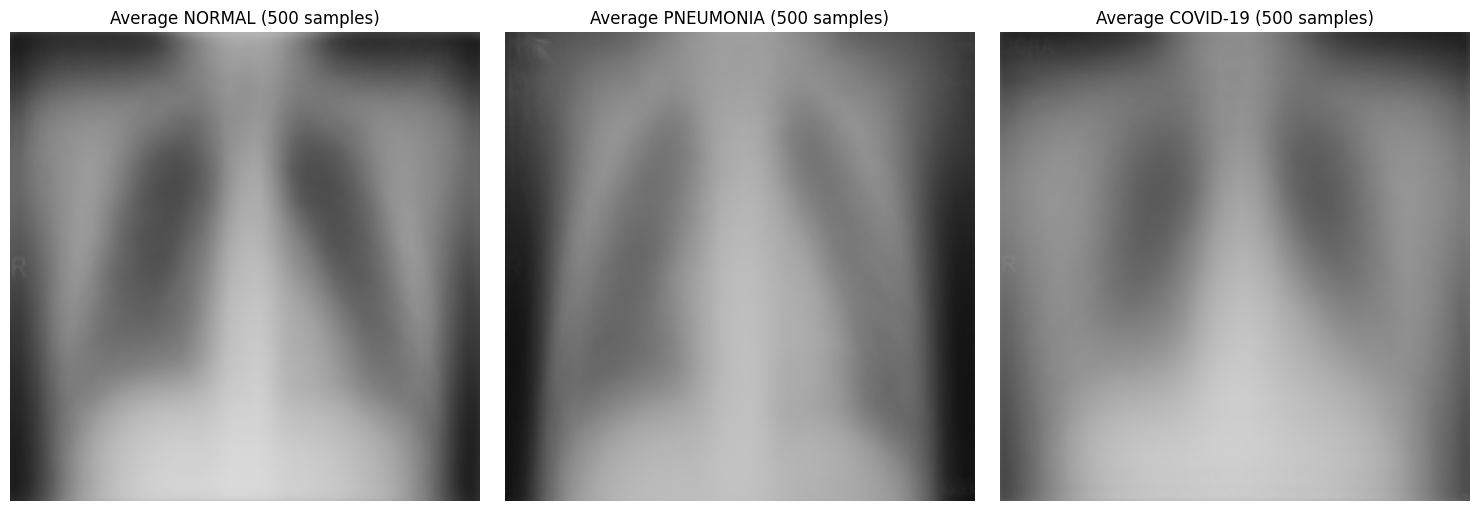

In [ ]:
import numpy as np
import random

def show_average_images(num_samples=500):
    plt.figure(figsize=(15, 5))
    classes = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    
    # Helper to get random images
    def get_random_images(label, n):
        images = []
        # 1. DATA_DIR (Paul Mooney)
        if label in ['NORMAL', 'PNEUMONIA']:
            p = os.path.join(DATA_DIR, 'train', label)
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpeg', '.jpg', '.png'))]
                images.extend(imgs)
        
        # 2. COVID_DIR (Tawsifur Rahman)
        if label == 'COVID-19':
            files = glob.glob(os.path.join(COVID_DIR, '**', 'COVID', 'images', '*.png'), recursive=True)
            images.extend(files)
        elif label == 'NORMAL':
            files = glob.glob(os.path.join(COVID_DIR, '**', 'Normal', 'images', '*.png'), recursive=True)
            images.extend(files)
        elif label == 'PNEUMONIA':
            files = glob.glob(os.path.join(COVID_DIR, '**', 'Viral Pneumonia', 'images', '*.png'), recursive=True)
            images.extend(files)

        # 3. PRASHANT_DIR
        if label == 'COVID-19':
            p = os.path.join(PRASHANT_DIR, 'train', 'COVID19')
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpg', '.png'))]
                images.extend(imgs)
        elif label in ['NORMAL', 'PNEUMONIA']:
            p = os.path.join(PRASHANT_DIR, 'train', label)
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpg', '.png'))]
                images.extend(imgs)

        # 4. Bachrr (COVID-19)
        if label == 'COVID-19' and os.path.exists(BACHRR_DIR):
             csv_path = os.path.join(BACHRR_DIR, 'metadata.csv')
             images_dir = os.path.join(BACHRR_DIR, 'images')
             if os.path.exists(csv_path) and os.path.exists(images_dir):
                 try:
                     df = pd.read_csv(csv_path)
                     covid_df = df[df['finding'].str.contains('COVID-19', na=False)]
                     files = covid_df['filename'].tolist()
                     files = [os.path.join(images_dir, f) for f in files if os.path.exists(os.path.join(images_dir, f))]
                     images.extend(files)
                 except Exception as e:
                     print(f"Error reading Bachrr: {e}")

        if images:
            return random.sample(images, min(len(images), n))
        return []

    for idx, label in enumerate(classes):
        sample_paths = get_random_images(label, num_samples)
        if not sample_paths: 
            print(f"No images found for {label}")
            continue
            
        avg_img = np.zeros((224, 224, 3), float)
        count = 0
        
        for img_path in sample_paths:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                avg_img += img
                count += 1
        
        if count > 0:
            avg_img = avg_img / count
            avg_img = np.array(avg_img, dtype=np.uint8)
            avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, 3, idx + 1)
            plt.imshow(avg_img)
            plt.title(f"Average {label} ({count} samples)")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Calculating average images... (This process may take a while)")
show_average_images()